In [102]:
import pandas as pd
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from scipy.spatial.distance import cosine
import itertools
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
from collections import Counter
import codecs
import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [24]:
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

Here we load the json arrays from Mongo and output a csv file, i.e. a pandas dataframe. 
This DF will be used for the CADE training.

Provo senza Wikipedia

In [27]:
df_list = pd.DataFrame()
for filename in glob.glob('./data_final/*.json'):
    print(filename)
    with open(filename, 'r') as f:
        json_load = json.loads(f.read())
        df_list = df_list.append(pd.DataFrame.from_records(json_load, index="_id"), ignore_index = True)

./data_final/scraping_data_CNN.json
./data_final/scraping_data_Federalist.json
./data_final/scraping_data_NewsMax.json
./data_final/scraping_data_ABC.json
./data_final/scraping_data_Breitbart.json
./data_final/scraping_data_NYTimes.json
./data_final/scraping_data_Slate.json


In [28]:
df_list = df_list[['Title', "Date", "Link", "Paragraphs", "Authors"]]

In [29]:
def create_newssite(link = None):
        if link is np.nan:
            return("Wikipedia")
        elif "slate" in link:
            return("Slate")
        elif "https://www.nytimes.com" in link:
            return("New York Times")
        elif "https://www.breitbart.com" in link:
            return("Breitbart")
        elif "https://www.cnn.com" in link:
            return("CNN")
        elif "abcnews" in link:
            return("ABC News")
        elif "https://thefederalist.com" in link:
            return("The Federalist")
        elif "https://www.newsmax.com" in link:
            return("News Max")
        else:
            return("Unknown")

In [30]:
df_list["Newssite"] = df_list["Link"].apply(create_newssite)

if len(df_list[df_list["Newssite"][:] == "Unknown"]) == 0:
    print("AVVOCATO CI SIAMO")

AVVOCATO CI SIAMO


In [31]:
with open("./data_safe.csv", 'w') as file:
    df_list.to_csv(file)

# CADE

## Embedding totale

First, we create a big text with everything. Like, EVERYTHING.

In [32]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')

df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

EVERYTHING = ""
for k in df["Paragraphs"]:
    EVERYTHING += "\n".join(k)

In [33]:
EVERYTHING = simple_preproc(EVERYTHING).lower()

In [34]:
with open("./EVERYTHING.txt", 'w') as file:
    file.write(EVERYTHING)

In [35]:
aligner = CADE(size=100, workers=8)

aligner.train_compass("./EVERYTHING.txt", overwrite=False) # keep an eye on the overwrite behaviour

Training the compass from scratch.


## Embedding singolo slice

In [36]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')
    
df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

for i, Newssite in enumerate(df["Newssite"].unique()):
    print("[INFO] Progress:"+str(i+1)+"/"+str(len(df["Newssite"].unique())))
    newssite_to_text = ""
    for k in df[df["Newssite"] == Newssite]["Paragraphs"][:]:
        newssite_to_text += "\n".join(k)

    with open("./text_"+str(Newssite)+".txt", 'w') as file:
        file.write(newssite_to_text)

[INFO] Progress:1/7
[INFO] Progress:2/7
[INFO] Progress:3/7
[INFO] Progress:4/7
[INFO] Progress:5/7
[INFO] Progress:6/7
[INFO] Progress:7/7


In [37]:
slices = {
            Newssite: aligner.train_slice("./text_"+str(Newssite)+".txt", save=False)
            for Newssite in df["Newssite"].unique()
         }

Training embeddings: slice ./text_CNN.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_The Federalist.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_Slate.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_News Max.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_ABC News.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_Breitbart.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_New York Times.txt.
Initializing embeddings from compass.


In [38]:
# Dobbiamo andare a salvare i vari slice
for my_slice in slices:
    slices[my_slice].save("models/"+str(my_slice)+".model")

## Visualizzazione medie

In [39]:
def sum_vectors(my_slice = None):
    my_sum = 0
    for i, word in enumerate(my_slice.wv.vocab):
        my_sum += my_slice.wv[word]
    return(my_sum/len(my_slice.wv.vocab))

In [40]:
my_sum = [sum_vectors(slices[my_slice]) 
       for i, my_slice in enumerate(slices)]

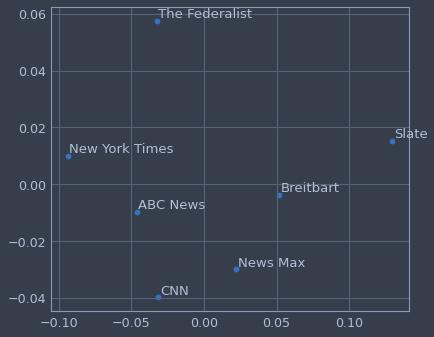

In [43]:
X_tranf = PCA(n_components=2).fit_transform(my_sum)
plt.scatter(X_tranf[:, 0], X_tranf[:, 1])
for index, word in enumerate(slices):
    plt.annotate(word, xy=(X_tranf[index, 0]+0.001, X_tranf[index, 1]+0.001))
plt.show()

In [44]:
print(np.array([[int((1 - cosine(my_sum[j], my_sum[i]))*100)/100
  for j in range(len(slices))] 
 for i in range(len(slices))]))

[[1.   0.98 0.92 0.98 0.98 0.97 0.97]
 [0.98 1.   0.93 0.98 0.98 0.97 0.97]
 [0.92 0.93 1.   0.95 0.91 0.97 0.88]
 [0.98 0.98 0.95 1.   0.98 0.99 0.96]
 [0.98 0.98 0.91 0.98 1.   0.96 0.98]
 [0.97 0.97 0.97 0.99 0.96 1.   0.94]
 [0.97 0.97 0.88 0.96 0.98 0.94 1.  ]]


In [45]:
for i, my_slice_1 in enumerate(slices):
    for j, my_slice_2 in enumerate(slices):
        print(i, j)
        print(1 - cosine(my_sum[j], my_sum[i]))

0 0
1.0
0 1
0.9801865816116333
0 2
0.922740638256073
0 3
0.9888353943824768
0 4
0.9895654320716858
0 5
0.9737983345985413
0 6
0.9770311713218689
1 0
0.9801865816116333
1 1
1.0
1 2
0.9342929124832153
1 3
0.9802963137626648
1 4
0.9849002361297607
1 5
0.9758275151252747
1 6
0.9740927815437317
2 0
0.922740638256073
2 1
0.9342929124832153
2 2
1.0
2 3
0.9576170444488525
2 4
0.9185029864311218
2 5
0.974017858505249
2 6
0.8862552046775818
3 0
0.9888353943824768
3 1
0.9802963137626648
3 2
0.9576170444488525
3 3
1.0
3 4
0.9819694757461548
3 5
0.9906207323074341
3 6
0.9627289175987244
4 0
0.9895654320716858
4 1
0.9849002361297607
4 2
0.9185029864311218
4 3
0.9819694757461548
4 4
1.0
4 5
0.9691888689994812
4 6
0.9831240177154541
5 0
0.9737983345985413
5 1
0.9758275151252747
5 2
0.974017858505249
5 3
0.9906207323074341
5 4
0.9691888689994812
5 5
1.0
5 6
0.9466882348060608
6 0
0.9770311713218689
6 1
0.9740927815437317
6 2
0.8862552046775818
6 3
0.9627289175987244
6 4
0.9831240177154541
6 5
0.9466882

# Lexicon Refinement

In questa sezione andiamo a prendere un Lexicon già [fatto](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). Questo possiede due score: noi chiamiamo 0 quello per l'oggettività, e 1 per la soggettività. 

## Pre-processing Lexicon

In [47]:
with open("./lexicon/subjectivityLexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, engine='c', sep=';', header=None)

lexicon.columns = ["Word", "Subj_score"]

# Facciamo un po' di pulizia prima di procedere
lexicon["Word"] = lexicon["Word"].apply(lambda x: x.replace("word1=", ""))
lexicon["Subj_score"] = lexicon["Subj_score"].apply(lambda x: 
                                                    x.replace("type=", ""))

In [48]:
def encode_subj(string_score = None):
    if string_score == "weaksubj":
        return(0)
    elif string_score == "strongsubj":
        return(1)
    else:
        print('[ERROR] Some problems occurd.')
        return(-1)

In [49]:
lexicon["Subj_score"] = lexicon["Subj_score"].apply(encode_subj)

In [50]:
with open("./lexicon/clean_lexicon.csv", 'w') as file:
    lexicon.to_csv(file)

## LRP

In [51]:
from nicoli_utils import *

In [52]:
# Caricamento del lexicon
with open("./lexicon/clean_lexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, index_col=1)

# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [53]:
lexicon = lexicon.drop("Unnamed: 0", axis=1)

lexicon = lexicon.to_dict()["Subj_score"]

In [54]:
models_test = [slices["New York Times"], slices["Breitbart"]]

In [55]:
corpora_test = ["./text_New York Times.txt", "./text_Breitbart.txt"]

In [56]:
lexicon_refined = lexicon_refinement(lex = lexicon, 
                   models = models_test, 
                   corpora = corpora_test, zipf_cutoff=5)

count text_New York Times
min_count text_New York Times
zipf text_New York Times
count text_Breitbart
min_count text_Breitbart
zipf text_Breitbart
dataframe done
common filter done


In [57]:
print(len(lexicon_refined))
print(len(lexicon_refined[lexicon_refined == 1]))

131
39


## Lexicon Enrichment

Su consiglio di Nicoli, facciamo prima l'arricchimento della classe meno frequente (nel nostro caso quella con `1`). 

Per eseguirla, usiamo una funzione già costruita dal nostro assistente preferito.

In [58]:
# Dobbiamo fare così per come è costruita la funzione di Nicoli
lexicon_refined[lexicon_refined == 0] = -1

In [59]:
lexicon_refined

ability    -1.0
able       -1.0
actually    1.0
against    -1.0
allow      -1.0
           ... 
war        -1.0
well       -1.0
white      -1.0
will        1.0
would      -1.0
Name: Valence, Length: 131, dtype: float64

In [61]:
vectorized_lexicon, lexicon_labels = enrich(lex = lexicon_refined, 
       models = models_test, 
       n_target = 300, 
       msteps = 200, 
       return_words = False)

  0%|          | 0/53 [00:00<?, ?it/s]

Balancing:  53


  0%|          | 0/116 [00:00<?, ?it/s]

Growing:  116


100%|██████████| 116/116 [01:08<00:00,  1.69it/s]


In [62]:
with open("./lexicon/enriched_lexicon.csv", 'w') as file:
    pd.DataFrame({"Vectorized_words": vectorized_lexicon.tolist(), 
              "Labels": lexicon_labels}).to_csv(file)

# Score Induction Nicoli

La procedura di di Nicoli è quella di applicare una **regressione logistica** usando il lessico aumentato come *training set*. 

In [63]:
with open("./lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [64]:
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

In [65]:
X = enriched_lexicon["Vectorized_words"].tolist()
y = enriched_lexicon["Labels"]
logistic = LogisticRegression(random_state=0).fit(X, y)

In [66]:
logistic.score(X, y)

0.95

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
score_train = []
score_test = []
#Cs = [10**x for x in range(-2, 5)]
Cs = np.arange(0.01, 10, 0.01)
best_C = 666
best_score = 0
for c in Cs:
    inducer = svm.SVC(C = c, kernel = 'poly').fit(X_train, y_train)
    score_train.append(inducer.score(X_train, y_train))
    score_test.append(inducer.score(X_test, y_test))
    if score_test[-1] > best_score:
        best_C = c
        best_score = score_test[-1]

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

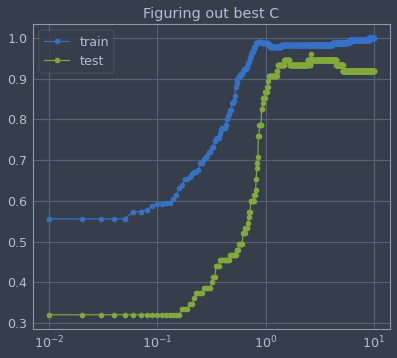

In [101]:
plt.plot(Cs, score_train, 'o-', label="train")
plt.plot(Cs, score_test, 'o-', label="test")
plt.legend()
plt.xscale('log')
plt.title("Figuring out best C")
plt.plot

[]

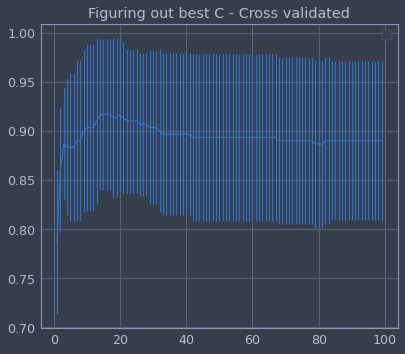

In [121]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(1, 100, 1)
for c in Cs:
    clf = svm.SVC(C=c, kernel = "poly")
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.title("Figuring out best C - Cross validated")
plt.plot()

# Il miglior valore è ~15